## DEEP FOOL ATTACK

In [1]:
import os
import copy
import math
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import random
from tensorflow.image import resize
from itertools import islice
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from keras.models import load_model



x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


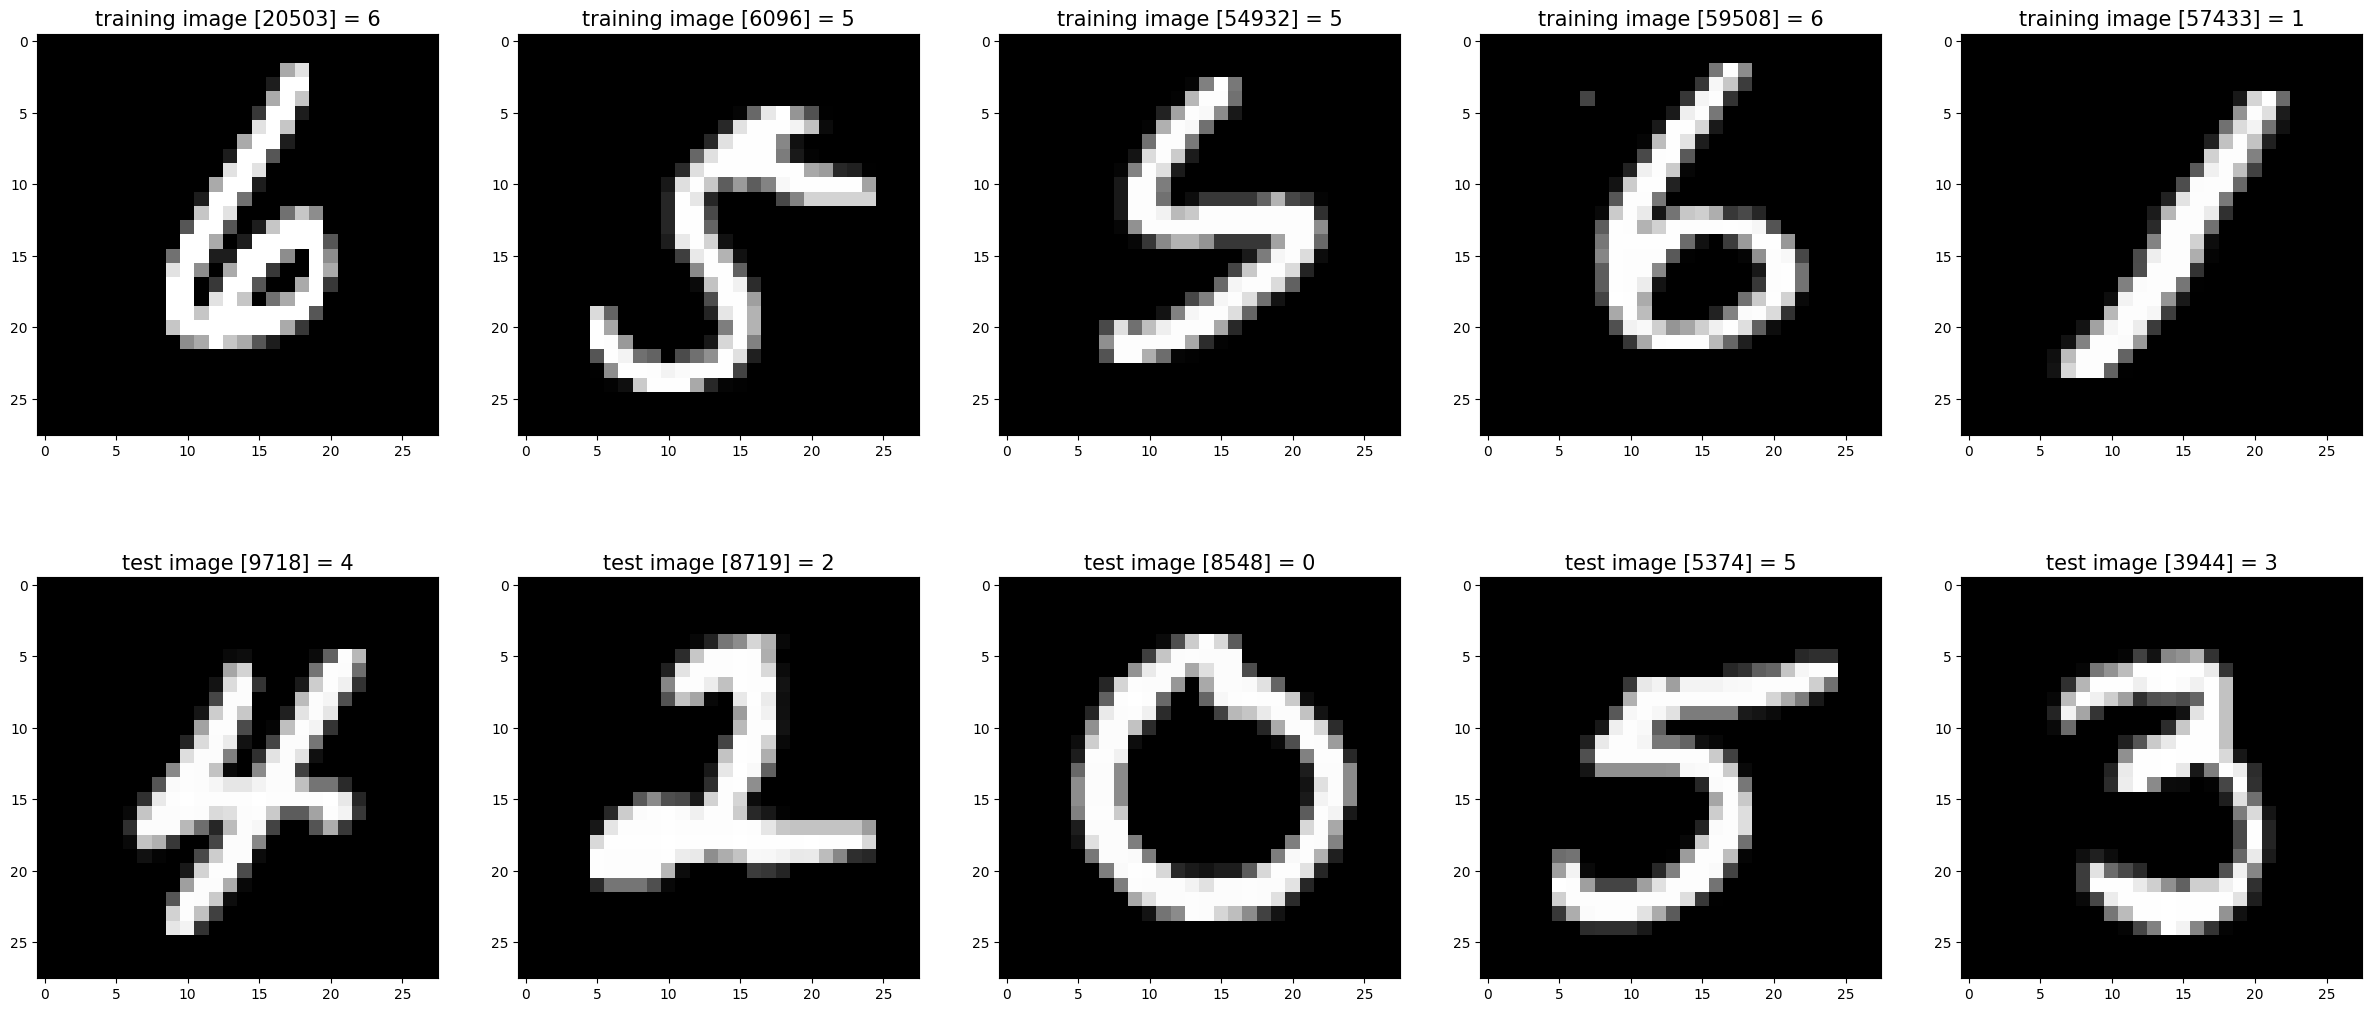

In [2]:
def show_images(images, title_texts):
    '''Function to show set of grayscale images with titles'''
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Loading dataset from keras (ref: https://keras.io/api/datasets/mnist/)
(x_train,y_train),(x_test,y_test)= keras.datasets.mnist.load_data()

# Print shapes
print('x_train shape: ', x_train.shape) # Train images
print('y_train shape: ', y_train.shape) # Train Labels
print('x_test shape: ', x_test.shape) # Test images
print('y_test shape: ', y_test.shape) # Test labels

# Show some random training and test images 
images_show = [] # random images placeholder
titles_show = [] # random images title placeholder
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_show.append(x_train[r])
    titles_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_show.append(x_test[r])        
    titles_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_show, titles_show)



Image set resized for lenet5. New shape is: (60000, 32, 32, 1)
Image set resized for vgg16. New shape is: (60000, 48, 48, 3)
5 becomes [0 0 0 0 0 1 0 0 0 0]
0 becomes [1 0 0 0 0 0 0 0 0 0]....
Image set resized for lenet5. New shape is: (10000, 32, 32, 1)
Image set resized for vgg16. New shape is: (10000, 48, 48, 3)
7 becomes [0 0 0 0 0 0 0 1 0 0]
2 becomes [0 0 1 0 0 0 0 0 0 0]....


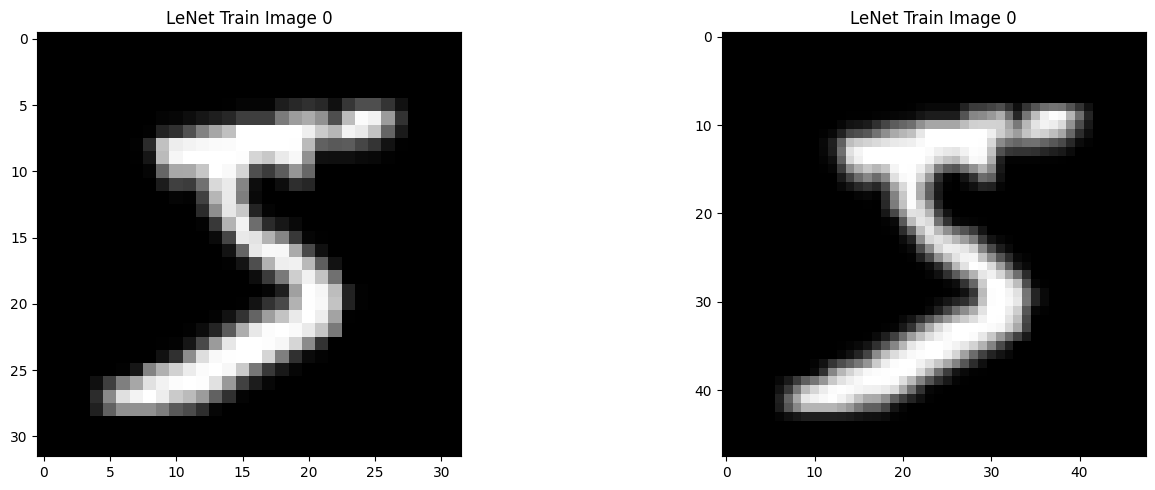

In [3]:
def resize_and_process_images_for_model(image_set, model):
    '''Function to resize image sets based on give model'''
    if model == 'lenet5':
        images_resized = np.expand_dims(image_set, axis=-1) # Add channel
        # convert image values from integers to floats
        images_resized = images_resized.astype('float32')
        # normalization
        images_resized = images_resized/255.0
        # resize
        images_resized = resize(images_resized, [32,32], antialias=True, method='bilinear') # if we want to resize
        images_resized = images_resized.numpy() # Need to convert to numpy to prevent error when using train_test_split()

    if model == 'vgg16':
        images_resized = np.expand_dims(image_set, axis=-1) #add new dimension at the end of the array shape.
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Repeat the channel dimension three times
        # convert image values from integers to floats
        images_resized = images_resized.astype('float32')
        # normalization
        images_resized = images_resized/255.0
        images_resized = resize(images_resized, [48,48], antialias=True, method='bilinear') # if we want to resize
        images_resized = images_resized.numpy() # Need to convert to numpy to prevent error when using train_test_split()
        #images_resized = np.dstack([images_resized] * 3) # Alternate method to add channels
    
    if model == 'inceptionv1':
        images_resized = np.expand_dims(image_set, axis=-1) #add new dimension at the end of the array shape.
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Repeat the channel dimension three times
        images_resized = resize(images_resized, [224,224], antialias=True, method='bilinear') # if we want to resize 
        images_resized = images_resized.numpy()  # Need to convert to numpy to prevent error when using train_test_split()
        #images_resized = np.dstack([images_resized] * 3) # Alternate method to add channels
        
    print(f'Image set resized for {model}. New shape is:', images_resized.shape)
    
    return images_resized

# Resize training images for LeNet5
lenet_xtrain = resize_and_process_images_for_model(x_train, 'lenet5')

vgg16_xtrain = resize_and_process_images_for_model(x_train, 'vgg16')

lb = LabelBinarizer() # Create the binary matrix
# Convert label to list
y_train_list = list(y_train)
# One-hot encode these labels
y_train_one_hot = lb.fit_transform(y_train_list) # Fit the binary matrix
print(f'{y_train[0]} becomes {y_train_one_hot[0][:]}')
print(f'{y_train[1]} becomes {y_train_one_hot[1][:]}....')

# Resize training images for LeNet5
lenet_xtest = resize_and_process_images_for_model(x_test, 'lenet5')

vgg16_xtest = resize_and_process_images_for_model(x_test, 'vgg16')

# Convert label to list
y_test_list = list(y_test)
# One-hot encode these labels
y_test_one_hot = lb.fit_transform(y_test_list) # Fit the binary matrix
print(f'{y_test[0]} becomes {y_test_one_hot[0][:]}')
print(f'{y_test[1]} becomes {y_test_one_hot[1][:]}....')

# Plot the images of each
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns - currently adjust to just display LeNet and VGG16

# Plot an image from LeNet training set
axes[0].imshow(lenet_xtrain[0][:, :, 0], cmap='gray')  # For grayscale image
axes[0].set_title('LeNet Train Image 0')  # Set title if needed
axes[0].axis('on')  # Turn off axis

# Plot an image from LeNet training set
axes[1].imshow(vgg16_xtrain[0][:, :, 0], cmap='gray')  # For grayscale image
axes[1].set_title('LeNet Train Image 0')  # Set title if needed
axes[1].axis('on')  # Turn off axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Original Code

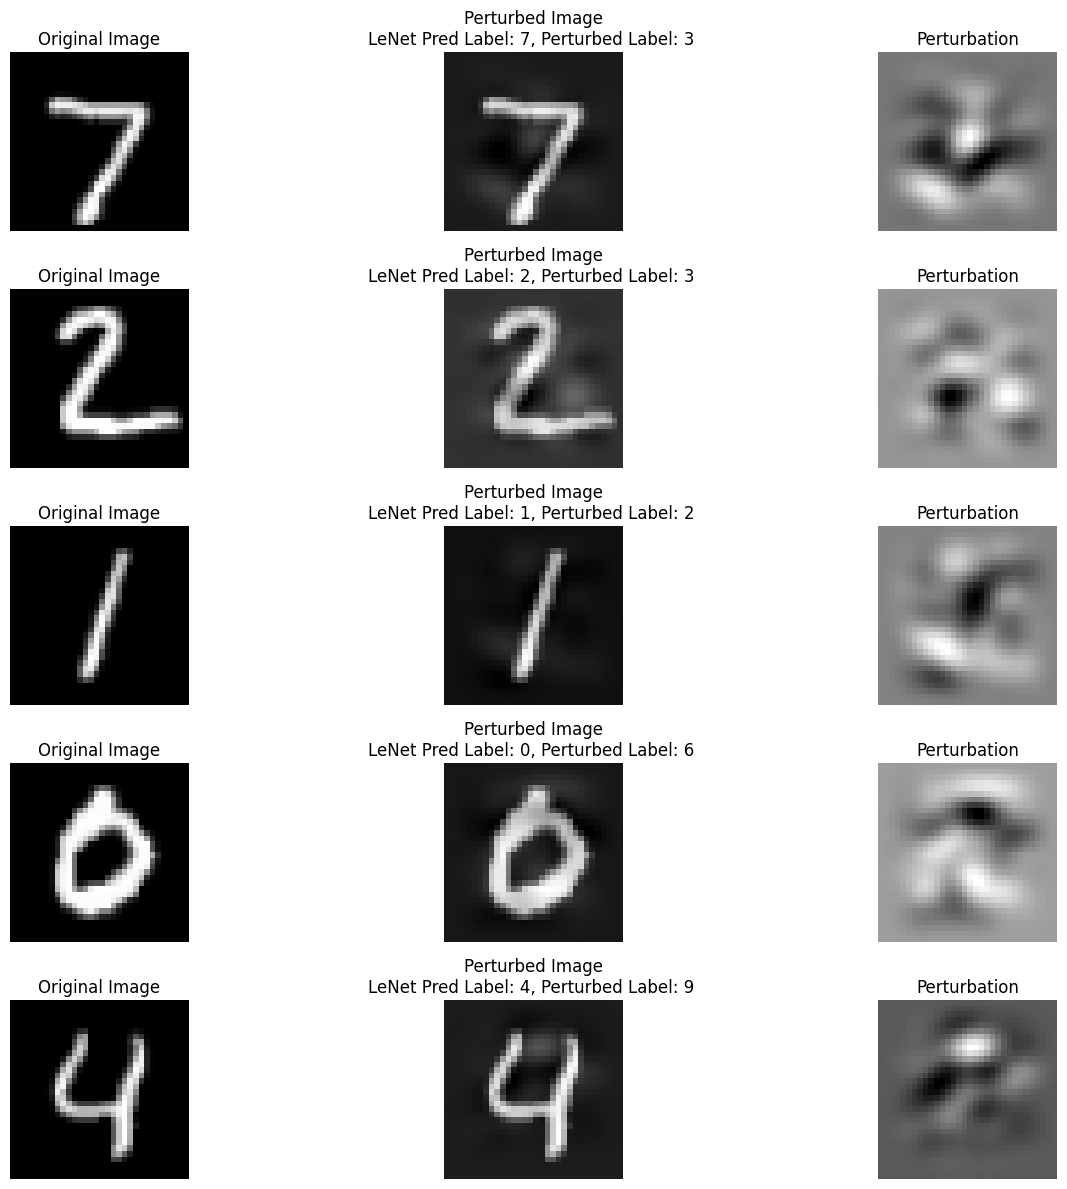

In [4]:
'''
Inputs:
    model : pre-existing trained model
    test_image : Test image of size Height x Wight x 1 for example: (32, 32, 1)
    num_classes : For MNIST dataset, there are 10 classes (10 digits to detect)
    overshoot : Rate of alteration inflicted onto the image
    max_iter : Max number of iterations for DeepFool Method

Outputs:
    pert_image : Perturbated image
    loop_i : Iterative count to produce the perturbated image
    label : True Label predicted by the passed-in model
    k_i : New predicted label by the passed-in model
    calc_min_pert_vec : Minimal pertubation calculated for the model to misclassify 

Reference Used:
    https://github.com/LTS4/DeepFool/blob/master/Python/deepfool.py
    
'''
def deepfool(model, test_image, num_classes=10, overshoot=0.01, max_iter=50):
    # Add a dimension to convert image of (32, 32, 1) to (1, 32, 32, 1)
    image = tf.expand_dims(test_image, axis=0)

    # Convert the image to a tensorflow object
    #tf_image = tf.convert_to_tensor(image)
    f_image = model(image)
    
    # Network predictions indices are sorted in descending order
    I = np.argsort(f_image).flatten()[::-1]
    I = I[0:num_classes]
    true_label = I[0]   # First label with the highest probability

    #TODO: DISPLAY THE f_image here for verification
    
    # Create a copy of original image to create the pertubed image
    # Initialize pertunation vector
    input_shape = image.shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    calc_min_pert_vec = np.zeros(input_shape)
    count_i = 0  # Counter for max iterations

    # Iterate till max_iter
    while count_i < max_iter:
        # Create Tensorsflow variable 
        tensor_var = tf.Variable(pert_image, dtype=tf.float32)

        # Gradient Calculation
        with tf.GradientTape(persistent=True) as tape:
            fs = model(tensor_var, training=False)  # returns a tensor object array 
            k_i = true_label
            pert = np.inf
            # Calc gradient of the predicted class
            grad_orig = tape.gradient(fs[0, I[0]], tensor_var).numpy()

            # Iterate through the classes to calculate the perturbation and gradient difference
            for k in range(1, num_classes):
                cur_grad = tape.gradient(fs[0, I[k]], tensor_var).numpy()
                w_k = cur_grad - grad_orig
                f_k = (fs[0, I[k]] - fs[0, I[0]]).numpy()
                pert_k = abs(f_k) / np.linalg.norm(w_k.flatten())

                # Update the perturbation with lower pert_k
                if pert_k < pert:
                    pert = pert_k
                    w = w_k

            # Calc minimal perturbation and apply to the image
            min_pert = (pert + 1e-4) * w / np.linalg.norm(w)
            calc_min_pert_vec = np.float32(calc_min_pert_vec + min_pert)
            pert_image = image + (1 + overshoot) * calc_min_pert_vec

            # Update the tensorflow variable with the perturbated image
            tensor_var.assign(pert_image)

            # Get model prediction on the perturbated image
            fs = model(tensor_var, training=False)
            k_i = np.argmax(fs.numpy().flatten())

            count_i += 1

        del tape

        # Break the loop if the prediction of the image has changed
        if k_i != true_label:
            break

    # Remove the batch dimension. 4D => 3D
    calc_min_pert_vec = (1 + overshoot) * calc_min_pert_vec.squeeze()   
    return calc_min_pert_vec, count_i, true_label, k_i, pert_image            


LeNet_model = load_model('./model_LeNet_no_softmax.h5')  # Corrected model path

# Assuming the first 5 images in the test set are used as examples
num_examples = 5
example_images = lenet_xtest[:num_examples]
example_labels = y_test_list[:num_examples]

plt.figure(figsize=(15, 12))
for i in range(num_examples):
    example_image = example_images[i]
    example_label = example_labels[i]
    #example_image /= 255.0 # Normalize to [0, 1]

    r_tot, loop_i, true_label, label_pert, pert_image = deepfool(LeNet_model, example_image)
    # Show Original Image
    plt.subplot(num_examples, 3, i*3 + 1)
    plt.imshow(example_image.squeeze(), cmap='gray')
    #plt.title("Original Image\nTrue Label: {}".format(example_label))
    plt.title("Original Image")
    plt.axis('off')

    # Perturbed Image
    plt.subplot(num_examples, 3, i*3 + 2)
    plt.imshow(pert_image.numpy().squeeze(), cmap='gray')
    #plt.title("Perturbed Image\nloop_i: {}, LeNet Pred Label: {}, Perturbed Label: {} ".format(loop_i, true_label, label_pert))
    plt.title("Perturbed Image\nLeNet Pred Label: {}, Perturbed Label: {} ".format(true_label, label_pert))
    plt.axis('off')

    # Perturbation (Difference) Image
    plt.subplot(num_examples, 3, i*3 + 3)
    plt.imshow(pert_image.numpy().squeeze() - example_image.squeeze(), cmap='gray')
    plt.title("Perturbation")
    plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

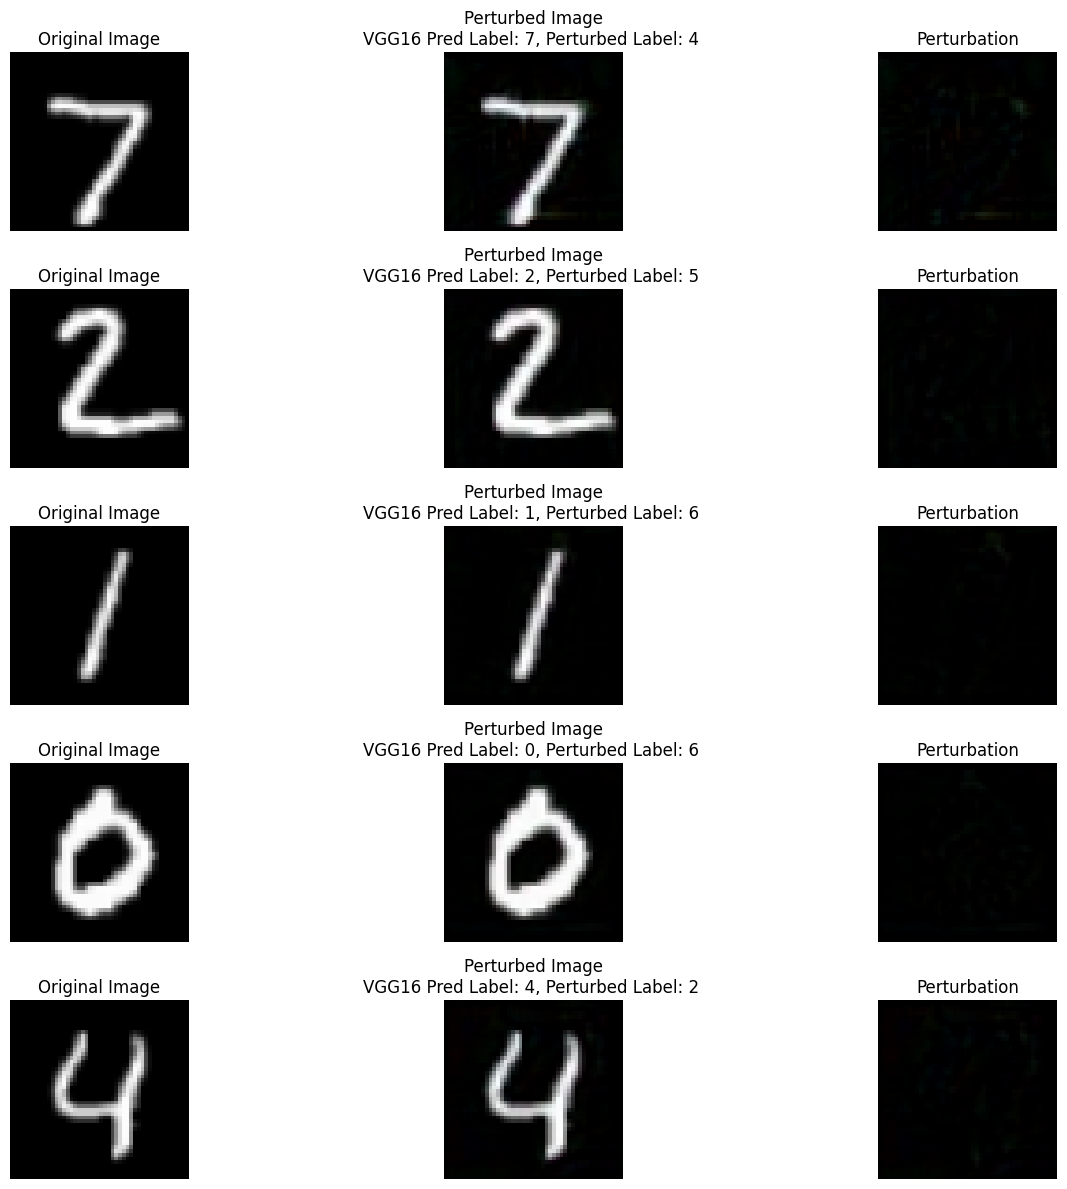

In [8]:
vgg16_model = load_model('./model_VGG16_no_softmax.h5')  # Corrected model path

# Assuming the first 5 images in the test set are used as examples
num_examples = 5
example_images = vgg16_xtest[:num_examples]
example_labels = y_test_list[:num_examples]

plt.figure(figsize=(15, 12))
for i in range(num_examples):
    example_image = example_images[i]
    example_label = example_labels[i]
    #example_image /= 255.0 # Normalize to [0, 1]

    r_tot, loop_i, true_label, label_pert, pert_image = deepfool(vgg16_model, example_image)
    # Show Original Image
    plt.subplot(num_examples, 3, i*3 + 1)
    plt.imshow(example_image.squeeze(), cmap='gray')
    #plt.title("Original Image\nTrue Label: {}".format(example_label))
    plt.title("Original Image")
    plt.axis('off')

    # Perturbed Image
    plt.subplot(num_examples, 3, i*3 + 2)
    plt.imshow(pert_image.numpy().squeeze(), cmap='gray')
    #plt.title("Perturbed Image\nloop_i: {}, LeNet Pred Label: {}, Perturbed Label: {} ".format(loop_i, true_label, label_pert))
    plt.title("Perturbed Image\nVGG16 Pred Label: {}, Perturbed Label: {} ".format(true_label, label_pert))
    plt.axis('off')

    # Perturbation (Difference) Image
    plt.subplot(num_examples, 3, i*3 + 3)
    plt.imshow(pert_image.numpy().squeeze() - example_image.squeeze(), cmap='gray')
    plt.title("Perturbation")
    plt.axis('off')

plt.tight_layout()
plt.show()